# Домашнее задание 6

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_6

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию координатного спуска (смотри семинар). 

Для такого метода подберите шаг $\gamma$ для наилучшей сходимости постройте график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число арифмитических операций при подсчете "градиента"). Постройте на этом же графике сходимость честного градиентного спуска c наилучшим шагом сходимости. Сделайте вывод о характере сходимости нового метода.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import random
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import load_svmlight_file
import time 
np.random.seed(4)

In [2]:
def generator(d, mu, L):
    D = np.diag(np.repeat([L, mu], [d / 2 + 1, d / 2 - 1]))
    Sample = (L - mu) * np.random.rand(d, d) + mu
    Q, _ = np.linalg.qr(Sample)
    A = Q.T @ D @ Q
    return A

In [3]:
seed = 20
d = 100
mu = 1
L = 1000
A = generator(d, mu, L)
b = np.random.randn(d) 

In [4]:
def nabla_f(x):
    return A @ x - b

def nabla_f_j(x, j):
    return A[j] @ x - b[j]

In [5]:
def const_gamma_gd(k):
    return 1.99 / L

def const_gamma_csgd(k, c):
    return c / (4 * L * d)

def dyn_gamma_csgd(k, c):
    return c / (k + L * d)

In [6]:
def GD(nabla_f, gamma, eps = 10**(-3)):
    error = []
    x_cur = np.random.randn(d)
    times = [0]
    time_now = 0
    
    while(True):
        start_time = time.time()
        x_new = x_cur - gamma(0) * nabla_f(x_cur)
        
        error.append(np.linalg.norm(nabla_f(x_cur))**2)
        
        if np.linalg.norm(nabla_f(x_cur))**2 < eps or len(error) > 10**5 // d:
            break
        
        x_cur = x_new
        
        end_time = time.time()
        time_now += end_time - start_time
        times.append(time_now)
        
    return x_new, error, times

In [7]:
def CSGD(nabla_f, gamma, batch_size = 1, independent = True, eps = 10**(-2), const = 1):
    error = []
    x_cur = np.random.randn(d)
    num_iter = 0
    times = [0]
    time_now = 0
    
    while(True):
        start_time = time.time()
        grad = np.zeros(x_cur.shape[0])
        
        if independent == True:
            for i in range(batch_size):
                np.random.seed(seed + num_iter + i)
                j = np.random.randint(d)
                grad[j] = nabla_f_j(x_cur, j)
        else:
            random.seed(seed + num_iter)
            for j in random.sample(range(d), batch_size):
                grad[j] = nabla_f_j(x_cur, j)
        
        x_new = x_cur - gamma(num_iter, const) * grad
        x_cur = x_new 
        
        end_time = time.time()
        time_now += end_time - start_time
        times.append(time_now)
        
        error.append(np.linalg.norm(nabla_f(x_new), ord = 2)**2)
        num_iter += 1
                                   
        if error[-1] < eps or num_iter > 5 * 10**5:
            break

    return x_new, error, times

In [8]:
constants = np.array([1, 300, 400, 500, 600])

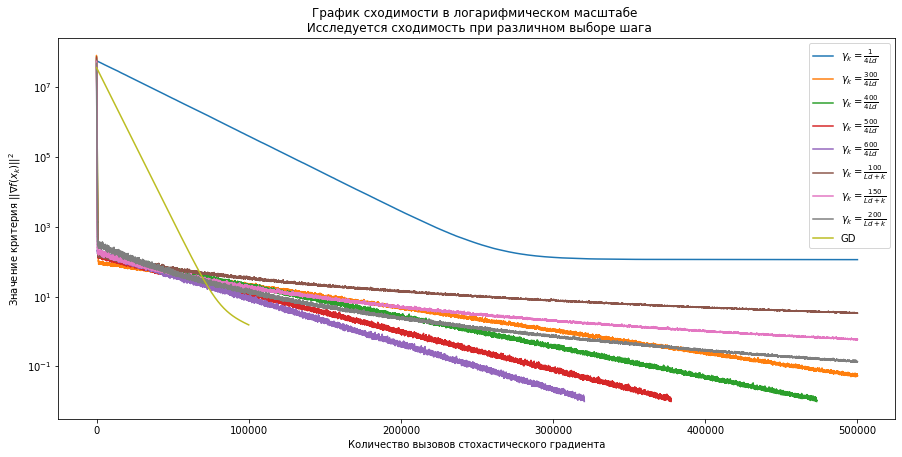

In [9]:
fig = plt.figure(figsize = (15, 7))

num_calls_csgd = 1
num_calls_gd = A.shape[0]

for c in constants:
    _, error, times = CSGD(nabla_f, gamma = const_gamma_csgd, independent = False, const = c)
    x = np.array(range(len(error))) * num_calls_csgd 
    plt.plot(x, error, label = r'$\gamma_k = \frac{%i}{4Ld}$' % c)
    
for c in [100, 150, 200] :
    _, error, times = CSGD(nabla_f, gamma = dyn_gamma_csgd, independent = False, const = c)
    x = np.array(range(len(error))) * num_calls_csgd 
    plt.plot(x, error, label = r'$\gamma_k = \frac{%i}{Ld + k}$' % c)
    
_, err_gd, _ = GD(nabla_f, const_gamma_gd)
x_gd = np.array(range(len(err_gd))) * num_calls_gd
plt.plot(x_gd, err_gd, label = 'GD')

plt.title("График сходимости в логарифмическом масштабе \n Исследуется сходимость при различном выборе шага")
plt.xlabel("Количество вызовов стохастического градиента")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно из графика, теория расходится с практикой, т.к. взяв большее значение шага, мы получили более быструю сходимость. Далее будем пользоваться значением $\gamma_k  = \frac{600}{4Ld}$.

__(б)__ В координатном спуске можно брать несколько координат вместо одной. Модифицируйте координнатный спуск, исходя из этого, пробуя разное число координат $b = 1, 5, 10, 20$, а также разные способы сэмплирования: все координатны независимо или зависимо, чтобы не было повторений в батче. Постройте графики аналогичные пункту (а). Сделайте вывод.

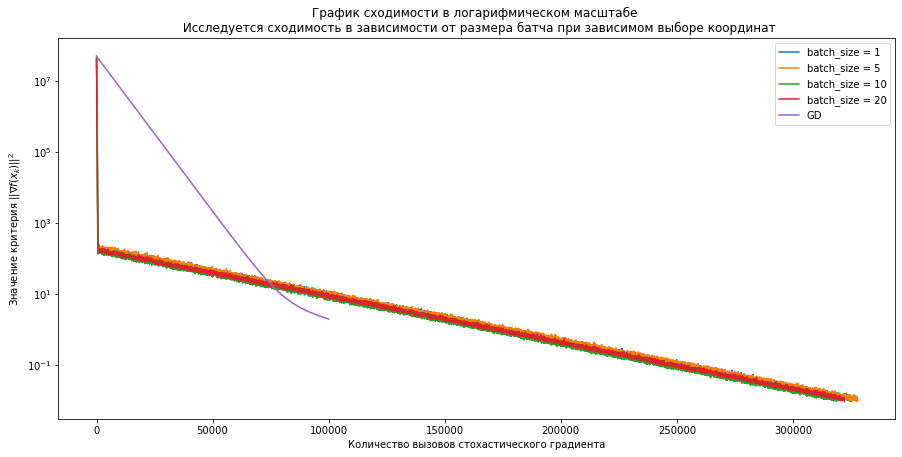

In [10]:
fig = plt.figure(figsize = (15, 7))

num_calls_gd = A.shape[0]

for size in [1, 5, 10, 20]:
    num_calls_csgd = size
    _, error, times = CSGD(nabla_f, gamma = const_gamma_csgd, batch_size = size, independent = False, const = 600)
    x = np.array(range(len(error))) * num_calls_csgd 
    plt.plot(x, error, label = 'batch_size = ' + str(size))
    
_, err_gd, _ = GD(nabla_f, const_gamma_gd)
x_gd = np.array(range(len(err_gd))) * num_calls_gd
plt.plot(x_gd, err_gd, label = 'GD')

plt.title("График сходимости в логарифмическом масштабе \n Исследуется сходимость в зависимости от размера батча при зависимом выборе координат")
plt.xlabel("Количество вызовов стохастического градиента")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

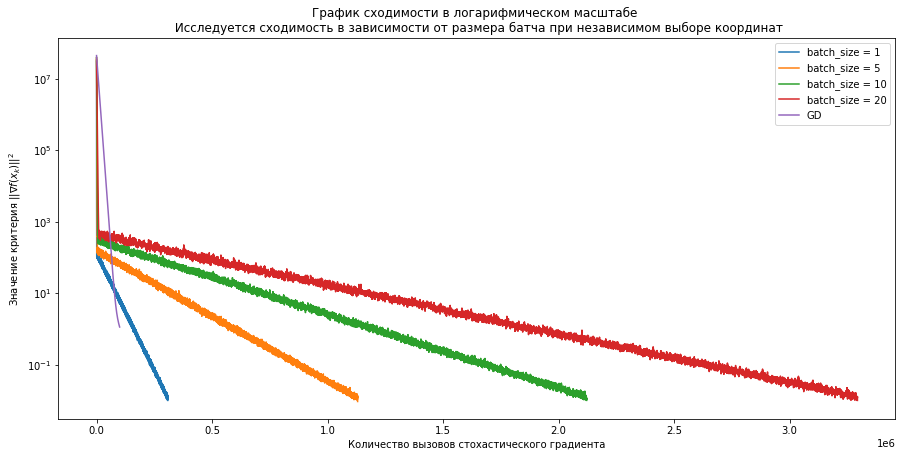

In [11]:
fig = plt.figure(figsize = (15, 7))

num_calls_gd = A.shape[0]

for size in [1, 5, 10, 20]:
    num_calls_csgd = size
    _, error, times = CSGD(nabla_f, gamma = const_gamma_csgd, batch_size = size, independent = True, const = 600)
    x = np.array(range(len(error))) * num_calls_csgd 
    plt.plot(x, error, label = 'batch_size = ' + str(size))
    
_, err_gd, _ = GD(nabla_f, const_gamma_gd)
x_gd = np.array(range(len(err_gd))) * num_calls_gd
plt.plot(x_gd, err_gd, label = 'GD')

plt.title("График сходимости в логарифмическом масштабе \n Исследуется сходимость в зависимости от размера батча при независимом выборе координат")
plt.xlabel("Количество вызовов стохастического градиента")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Из графиков выше понятно, что нужно выбирать координаты зависимо, что на самом деле достаточно очевидно, т.к. дважды обновлять одну и ту же координату хуже, чем обновить несколько разных, получая тем самым более точный градиент.

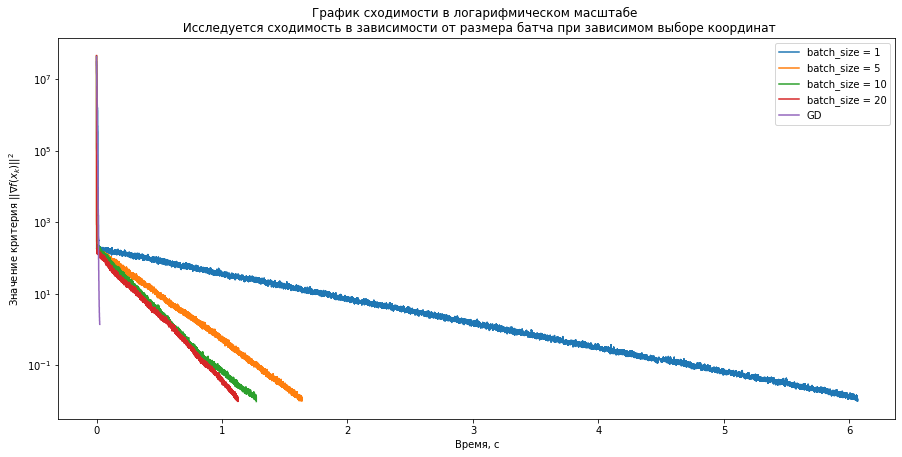

In [12]:
fig = plt.figure(figsize = (15, 7))

num_calls_gd = A.shape[0]

for size in [1, 5, 10, 20]:
    num_calls_csgd = size
    _, error, times = CSGD(nabla_f, gamma = const_gamma_csgd, batch_size = size, independent = False, const = 600)
    plt.plot(times[:-1], error, label = 'batch_size = ' + str(size))
    
_, err_gd, times = GD(nabla_f, const_gamma_gd)
plt.plot(times, err_gd, label = 'GD')

plt.title("График сходимости в логарифмическом масштабе \n Исследуется сходимость в зависимости от размера батча при зависимом выборе координат")
plt.xlabel("Время, с")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно из графиков, градиентный спуск работает быстрее, однако требует значительно больше вызовов стох градиента для заданной точности.

## Задача 2

Рассмотрим задачу линейной регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. 

In [13]:
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

In [14]:
y = pd.DataFrame(y)
y = np.array(y.replace(2, 0)).reshape(8124,)

Точно так же, как во втором домашнем задании получаем: $$f(w) = \frac{1}{n}\|Xw - y\|^2_2 = \frac{1}{n}\langle Xw - y, Xw - y\rangle = \frac{1}{n}\langle X^TXw, w\rangle - \frac{2}{n}\langle X^Ty, w\rangle + \frac{1}{n}\langle y, y\rangle$$ То есть мы имеем дело с квадратичной задачей, в прошлом дз мы показывали, что если матрица $A$ симметричная, а у нас $A = \frac{2}{n}X^TX$ - симметричная всегда, то для выпуклости достаточно $X^TX \succcurlyeq 0$, а для сильной выпуклости соответственно: $\frac{2}{n}X^TX\succcurlyeq \mu E$ или же $\mu \leq\lambda_{min}(\frac{2}{n}X^TX)$.

Константа $L$ оценивается из тех же соображений: $L = \lambda_{max}(A) = \lambda_{max}(\frac{2}{n}X^TX)$

Посмотрим, как оценить $\mu$:

In [15]:
print('Минимальное собственное число нашей матрицы: \n', 
      np.min(np.real(np.linalg.eigvals((2 / (X.shape[0])) * (X.T @ X)))))

Минимальное собственное число нашей матрицы: 
 -6.188109099283624e-16


Как известно из теории, у симметричной матрицы не может быть отрицательных собственных значений $\Rightarrow$ тут замешан машинный ноль, и оценить константу сильной выпуклости можно лишь нулем, т.е. задача не является сильно выпуклой.

In [16]:
A = (2 / X.shape[0]) * (X.T @ X)
b = (2 / X.shape[0]) * (X.T @ y)
d = X.shape[1]
L = max(np.real(np.linalg.eigvals((2 / (X.shape[0])) * (X.T @ X))))
mu = 0

In [17]:
def nabla_f(x):
    return A @ x - b + 2 * L / 1000 * x

def nabla_f_j(x, j):
    return A[j] @ x - b[j] + 2 * L / 1000 * x[j]

__(б)__ Реализуйте координатный SGD, SEGA для задачи линейно регрессии. Каким будете брать $b$? Как будете выбирать шаг и другие параметры методов?

Все гиперпараметры предлагаю подбирать экспериментально, за основу возьмем теоретическое значение шага $\gamma_k = \frac{1}{24Ld}$ и попробуем вместо $1$ в числителе подставлять другие константы. Затем также рассмотрим динамический шаг $\gamma_k = \frac{1}{k + Ld}$ и сделаем с ним то же самое.

Размер батча будем искать по сетке $[1, 5, 10, 20]$, значение взяты просто из рациональных соображений о том, что батч не должен быть слишком большой, иначе теряется смысл батчирования, а выбрать лучший среди небольших значений поможет эксперимент.

In [18]:
def const_gamma_SEGA(k, c):
    return c / (24 * L * d)

def dyn_gamma_SEGA(k, c):
    return c / (k + L * d)

In [19]:
def SEGA(nabla_f, gamma, batch_size = 1, eps = 10**(-4), const = 1):
    error = []
    x_cur = np.random.randn(d)
    num_iter = 0
    h = nabla_f(x_cur)
    times = [0]
    time_now = 0
    
    while(True): 
        start_time = time.time()
        np.random.seed(seed + num_iter)
        for j in random.sample(range(d), batch_size):
            h[j] = nabla_f_j(x_cur, j)

        x_new = x_cur - gamma(num_iter, const) * d * h
        x_cur = x_new
        
        error.append(np.linalg.norm(nabla_f(x_new), ord = 2)**2)
        num_iter += 1
        
        end_time = time.time()
        time_now += end_time - start_time
        times.append(time_now)
        
        if error[-1] < eps or num_iter > 10**5:
            break
        
    return x_new, error, times     

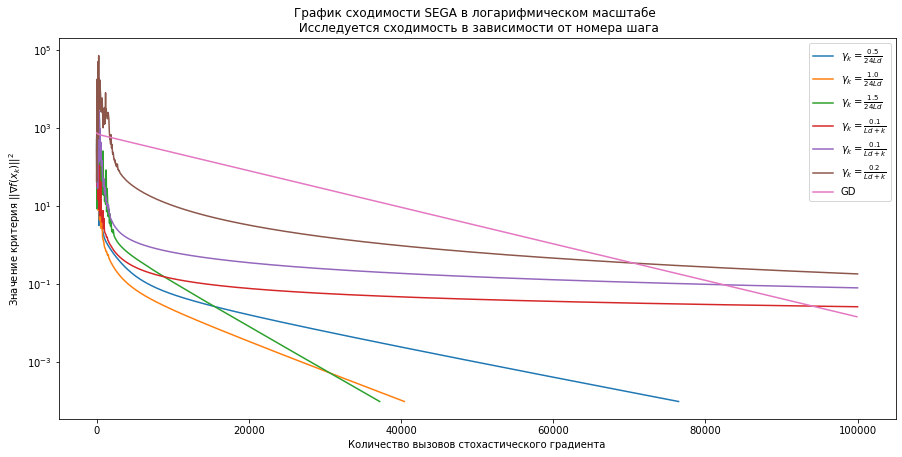

In [20]:
fig = plt.figure(figsize = (15, 7))

num_calls_SEGA = 1
num_calls_gd = A.shape[0]

for c in [0.5, 1, 1.5]:
    _, error, _ = SEGA(nabla_f, const_gamma_SEGA, const = c)
    x = np.array(range(len(error))) * num_calls_SEGA 
    plt.plot(x, error, label = r'$\gamma_k = \frac{%.1f}{24Ld}$' % c)
    
for c in [0.05, 0.1, 0.2] :
    _, error, _ = SEGA(nabla_f, gamma = dyn_gamma_SEGA, const = c)
    x = np.array(range(len(error))) * num_calls_SEGA 
    plt.plot(x, error, label = r'$\gamma_k = \frac{%.1f}{Ld + k}$' % c)
    
_, err_gd, _ = GD(nabla_f, const_gamma_gd)
x_gd = np.array(range(len(err_gd))) * num_calls_gd
plt.plot(x_gd, err_gd, label = 'GD')

plt.title("График сходимости SEGA в логарифмическом масштабе \n Исследуется сходимость в зависимости от номера шага")
plt.xlabel("Количество вызовов стохастического градиента")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Снова небольшие расхождения с теорией, лучше выбрать константу в числителе равной 1,5.

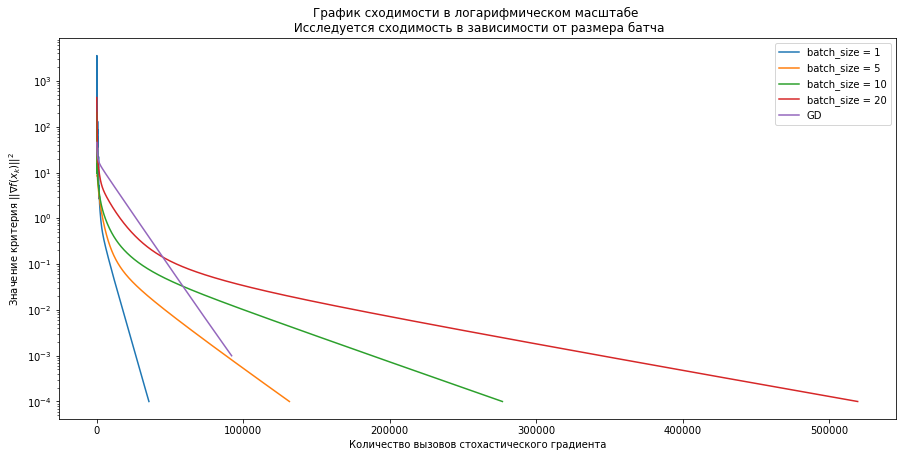

In [21]:
fig = plt.figure(figsize = (15, 7))

num_calls_gd = A.shape[0]

for size in [1, 5, 10, 20]:
    num_calls_SEGA = size
    _, error, _ = SEGA(nabla_f, const_gamma_SEGA, batch_size = size, const = 1.5)
    x = np.array(range(len(error))) * num_calls_SEGA 
    plt.plot(x, error, label = 'batch_size = ' + str(size))
    
_, err_gd, _ = GD(nabla_f, const_gamma_gd)
x_gd = np.array(range(len(err_gd))) * num_calls_gd
plt.plot(x_gd, err_gd, label = 'GD')

plt.title("График сходимости в логарифмическом масштабе \n Исследуется сходимость в зависимости от размера батча")
plt.xlabel("Количество вызовов стохастического градиента")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

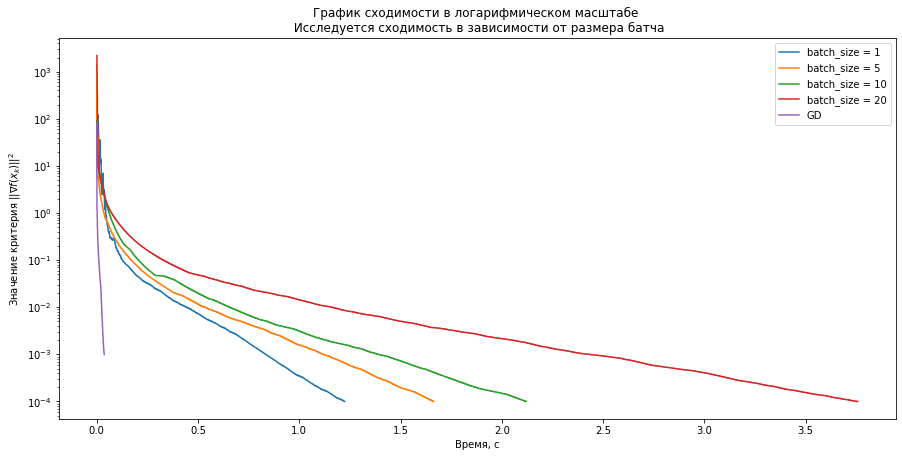

In [22]:
fig = plt.figure(figsize = (15, 7))

for size in [1, 5, 10, 20]:
    _, error, times = SEGA(nabla_f, const_gamma_SEGA, batch_size = size, const = 1.5)
    plt.plot(times[:-1], error, label = 'batch_size = ' + str(size))
    
_, err_gd, times = GD(nabla_f, const_gamma_gd)
plt.plot(times, err_gd, label = 'GD')

plt.title("График сходимости в логарифмическом масштабе \n Исследуется сходимость в зависимости от размера батча")
plt.xlabel("Время, с")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

По времени ничего по прежнему не бьет градиентный спуск, batch_size лучше всего выбирать равным единице.

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество арифметических операций, по оси $y$ - $\|\nabla f(x^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

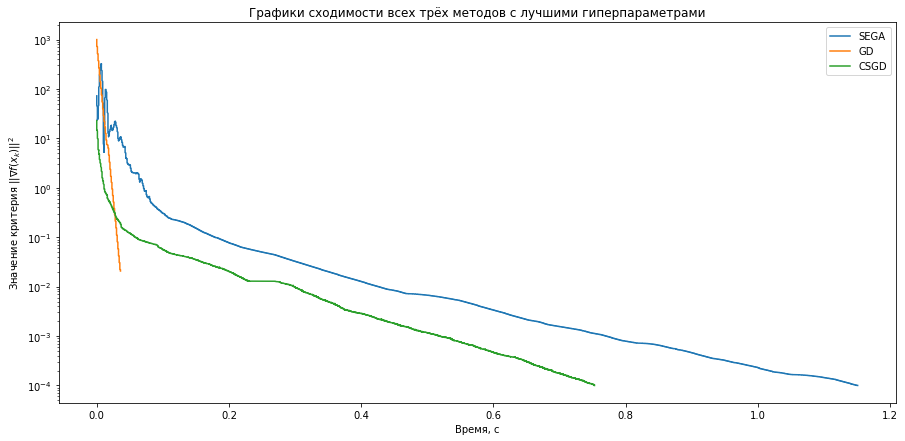

In [33]:
fig = plt.figure(figsize = (15, 7))

x_SEGA, error, times = SEGA(nabla_f, const_gamma_SEGA, batch_size = 1, const = 1.5, eps = 10**(-4))
plt.plot(times[:-1], error, label = 'SEGA')

x_GD, err_gd, times = GD(nabla_f, const_gamma_gd, eps = 10**(-4))
plt.plot(times, err_gd, label = 'GD')

x_CSGD, error, times = CSGD(nabla_f, gamma = const_gamma_csgd, batch_size = 20, independent = False, const = 600, eps = 10**(-4))
plt.plot(times[:-1], error, label = 'CSGD')

plt.title("Графики сходимости всех трёх методов с лучшими гиперпараметрами")
plt.xlabel("Время, с")
plt.ylabel(r"Значение критерия $||\nabla f(x_k)||^2$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно из графиков, обычный градиентый спуск хоть и работает быстрее, чем SEGA и CSGD, однако за $10^5$ итераций до точности $10^{-4}$ так и не сошелся, используя при этом гораздо больше вычислительных ресурсов(градиент то он считает полный). Посмотрим на итоговые точности:

In [34]:
print('Точность по метрике r2_score полученного с помощью CSGD решения: ', r2_score(X @ x_CSGD, y))
print('Точность по метрике r2_score полученного с помощью GD решения: ', r2_score(X @ x_GD, y))
print('Точность по метрике r2_score полученного с помощью SEGA решения: ', r2_score(X @ x_SEGA, y))

Точность по метрике r2_score полученного с помощью CSGD решения:  0.9409441614800883
Точность по метрике r2_score полученного с помощью GD решения:  0.9397078346093803
Точность по метрике r2_score полученного с помощью SEGA решения:  0.9422904303835924


Лучшая точность получилась у работавшей дольше всех SEGA.

__Бонусные пункты__

__(г)__ Попробуйте объеденить подходы SAGA/SVRG/L-SVRG и координатный SGD/SEGA (т.е. могут получиться пары SAGA + координатный, SVRG + SEGA и еще четыре других). Вам достаточно выбрать одну пару. Как при этом будет выглядеть итерация метода (запишите в явном виде)? Докажите сходимость данного подхода для $\mu$-сильно выпуклой $f$ и $L$-гладкой $f_i$.

In [25]:
#ответ

__(д)__ Реализуйте новый метод. Сравните его с двумя методами, которые были взяты за базу, на задаче линейной регресии. Способы сравнения методов придумайте самостоятельно. Сделайте вывод.

In [26]:
#ответ